In [1]:
#| default_exp data

# Data functionalities

> Generating and importing data

In [2]:
#| export
from types import SimpleNamespace
from torchvision.datasets import MNIST

In [3]:
PATH = "."

In [4]:
mnist = MNIST(PATH, download=True)
mnist

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train

In [5]:
mnist.data.shape

torch.Size([60000, 28, 28])

## Visualizing the dataset

In [6]:
from torch_moving_mnist.utils import show_image, show_images

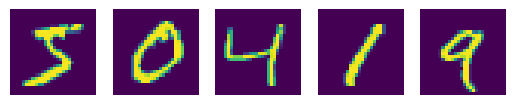

In [7]:
show_images(mnist.data[0:5]);

## Generating moving mnist sequences:

In [8]:
#| export
import random

import torch
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from fastprogress import progress_bar

mnist_stats    = ([0.131], [0.308])

We can leverage torchvision's affine transform!

In [9]:
digit = torch.tensor(mnist.data[[0]])

<AxesSubplot: >

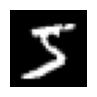

In [10]:
show_image(digit)

In [11]:
angle = 20  # rotation in degrees
scale = 1.3 # scaling in percentage (1.0 = no scaling)
translate = (2,3) # translation in pixels
shear = 15 # deformation on the z-plane

<AxesSubplot: >

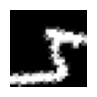

In [12]:
show_image(TF.affine(digit, angle, translate, scale, shear))

we should probably pad first, so we don't get out of the canvas

In [13]:
#| export
def padding(img_size=128, mnist_size=28): return (img_size - mnist_size) // 2

In [14]:
padding(64)

18

<AxesSubplot: >

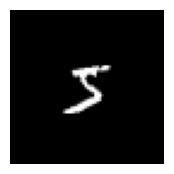

In [15]:
pdigit = TF.pad(digit, padding=18)  #18 give us a 64x64 image (18x2 + 28)
show_image(pdigit)

<AxesSubplot: >

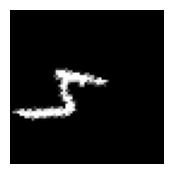

In [16]:
show_image(TF.affine(pdigit, angle, (-10,3), scale, shear))

In [17]:
#| export
def linear_schedule(a, b, n=5):
    "equivalent to np.linspace"
    return [i*(b-a)/(n-1) + a for i in range(n)]

In [18]:
linear_schedule(1,20)

[1.0, 5.75, 10.5, 15.25, 20.0]

In [19]:
angles = linear_schedule(-10,20)
angles

[-10.0, -2.5, 5.0, 12.5, 20.0]

In [20]:
#| export
affine_params = dict(
    angle=(-10, 10), # rotation in degrees (min and max values)
    translate=((-20, 20), (-20, 20)), # translation in pixels x and y
    scale=(.8, 1.3), # scaling in percentage (1.0 = no scaling)
    # shear=(-10, 10), # deformation on the z-plane
    shear=(0,0),
)

In [21]:
#| export
def random_linear_schedule(a, b, n=5):
    x = random.uniform(a,b)
    y = random.uniform(a,b)
    return linear_schedule(x, y, n=n)

In [22]:
random_linear_schedule(-10, 2)

[0.5049194776424422,
 -0.1782115380559861,
 -0.8613425537544144,
 -1.5444735694528426,
 -2.227604585151271]

In [23]:
random_linear_schedule(.8, 1.3)

[1.28019964910286,
 1.1701371006922365,
 1.060074552281613,
 0.9500120038709896,
 0.8399494554603661]

In [24]:
#| export
class Trajectory:
    def __init__(self, angle, translate, scale, shear, n=5):
        self.angle_schedule = random_linear_schedule(*angle, n=n)
        self.scale_schedule = random_linear_schedule(*scale, n=n)
        translate_x = random_linear_schedule(*translate[0], n=n)
        translate_y = random_linear_schedule(*translate[1], n=n)
        self.translate_schedule = list(zip(translate_x, translate_y))
        self.shear_schedule = random_linear_schedule(*shear, n=n)
        
    def points(self):
        return list(zip(self.angle_schedule , self.translate_schedule, self.scale_schedule, self.shear_schedule))
            
    def apply(self, img):
        return [TF.affine(img, *param) for param in self.points()]

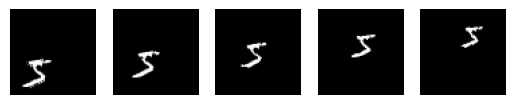

In [25]:
t = Trajectory(**affine_params)
show_images([TF.affine(pdigit, *param) for param in t.points()])

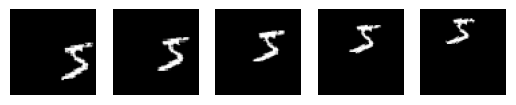

In [26]:
params = Trajectory(**affine_params)
show_images(params.apply(pdigit))

it also works on batches

In [27]:
two_pdigits = torch.stack([pdigit, pdigit], dim=0)

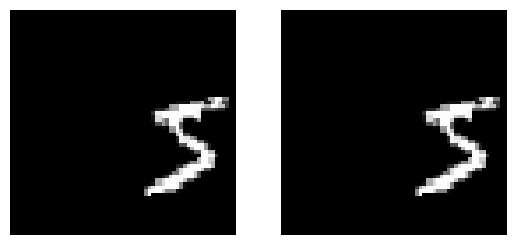

In [28]:
show_images(params.apply(two_pdigits)[0])

In [44]:
#| export
import math
import random

class MovingMNIST:
    def __init__(self, path=".",  # path to store the MNIST dataset
                 affine_params: dict=affine_params, # affine transform parameters, refer to torchvision.transforms.functional.affine
                 num_digits: list[int]=[3], # how many digits to move, random choice between the value provided
                 num_frames: int=4, # how many frames to create
                 img_size=64, # the canvas size, the actual digits are always 28x28
                 concat=True, # if we concat the final results (frames, 1, 28, 28) or a list of frames.
                 normalize=True, # scale images in [0,1] and normalize them with MNIST stats. Applied at batch level. Have to take care of the canvas size that messes up the stats!
                ):
        self.mnist = MNIST(path, download=True).data
        self.affine_params = affine_params
        self.num_digits = num_digits
        self.num_frames = num_frames
        self.img_size = img_size
        self.pad = padding(img_size)
        self.concat = concat
        
        # some computation to ensure normalizing correctly-ish
        batch_tfms = [T.ConvertImageDtype(torch.float32)]
        if normalize:
            ratio = (28/img_size)**2*max(num_digits)
            mean, std = mnist_stats
            scaled_mnist_stats = ([mean[0]*ratio], [std[0]*ratio])
            print(f"New computed stats for MovingMNIST: {scaled_mnist_stats}")
            batch_tfms += [T.Normalize(*scaled_mnist_stats)] if normalize else []
        self.batch_tfms = T.Compose(batch_tfms)  
    
    def random_digit(self):
        img = self.mnist[[random.randrange(0, len(self.mnist))]]
        return TF.pad(img, padding=self.pad) 
    
    def random_trajectory(self):
        return Trajectory(**self.affine_params, n=self.num_frames)
    
    def _one_moving_digit(self):
        digit = self.random_digit()
        traj = self.random_trajectory()
        return torch.stack(traj.apply(digit))
    
    def __getitem__(self, i):
        moving_digits = [self._one_moving_digit() for _ in range(random.choice(self.num_digits))]
        moving_digits = torch.stack(moving_digits)
        combined_digits = moving_digits.max(dim=0)[0]
        return combined_digits if self.concat else [t.squeeze(dim=0) for t in combined_digits.split(1)]
    
    def get_batch(self, bs=32):
        "Grab a batch of data"
        batch = torch.stack([self[0] for _ in range(bs)])
        return self.batch_tfms(batch) if self.batch_tfms is not None else batch
    
    def save(self, fname="mmnist.pt", n_batches=2, bs=32):
        data = [] 
        for _ in progress_bar(range(n_batches)):
            data.append(self.get_batch(bs=bs))
        
        data = torch.cat(data, dim=0)
        print("Saving dataset")
        torch.save(data, f"{fname}")

This is an random MNIST Dataset:

In [45]:
mnist[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [46]:
affine_params

{'angle': (-10, 10),
 'translate': ((-20, 20), (-20, 20)),
 'scale': (0.8, 1.3),
 'shear': (0, 0)}

In [49]:
ds = MovingMNIST(affine_params=affine_params, num_frames=10, num_digits=[1,2])

New computed stats for MovingMNIST: ([0.050148437500000004], [0.11790625])


torch.Size([10, 1, 64, 64])


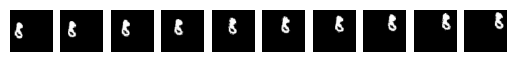

In [50]:
digits = ds[0]
print(digits.shape)
show_images(digits)

In [51]:
b = ds.get_batch(bs=32)
b.shape

torch.Size([32, 10, 1, 64, 64])

In [53]:
ds.save(n_batches=2, bs=16, fname="mini_mmnist.pt")

Saving dataset


without concat

In [33]:
ds.concat=False

In [34]:
type(ds[0]), ds[0][0].shape

(list, torch.Size([1, 64, 64]))

In [3]:
#| hide
import nbdev; nbdev.nbdev_export()